In [1]:
## Deep Learning
# import IPython
# import librosa
# import musdb
# root_directory='/Users/apple/Downloads/mus_stems'
# mus = musdb.DB(root_directory)
# tracks = mus.load_mus_tracks(subsets=['train'])
# vocals = tracks[0].targets['vocals'].audio
# sample_rate = tracks[0].rate
# IPython.display.Audio(data = vocals[:,0], rate = sample_rate)
# #Single instrument
# import musdb
# root_directory='/Users/apple/Downloads/mus_stems'
# mus = musdb.DB(root_directory)
# tracks = mus.load_mus_tracks(subsets=['train'])
# vocals = tracks[0].targets['vocals'].audio
# sample_rate = tracks[0].rate
# IPython.display.Audio(data = vocals[:,0], rate = sample_rate)

In [2]:
# print(tracks[0].targets['vocals'].sources)

In [3]:
## Compute STFT
# window_size = int(0.084*sample_rate)
# hop_size = int(0.01*sample_rate)
# Stft = librosa.stft(vocals[:,0], n_fft = window_size, hop_length=hop_size)
# Vft, phase = librosa.magphase(Stft)
# F,T = Vft.shape
# # Plot
# import numpy as np
# import matplotlib.pyplot as plt
# import librosa.display
# plt.figure(figsize=(10,5))
# librosa.display.specshow(librosa.amplitude_to_db(Vft,ref=np.max), 
#                          x_axis='time', y_axis='log', sr=sample_rate, hop_length=hop_size)
# plt.colorbar()
# plt.tight_layout()

In [4]:
## Normalize Vft
# def normalize(magnitude):
#     F,T=magnitude.shape
#     for t in range(T):
#         denominator = sum(magnitude[:,t])
#         for f in range(F): 
#             magnitude[f,t]=magnitude[f,t]/denominator

In [5]:
## Define custom filter
# import math
# sqrt = math.sqrt
# pi = math.pi
# exp = math.exp

# def gaussian(x,mu,sigma=3/8):
#     if x<0 : return 0
#     return (1/sqrt(2*pi*sigma))*exp(-(((x-mu)**2)/sigma**2))

# def multiple_gaussian(K,f,f0,sigma=3/8) :
#     # Multiple gaussian filters at the multiples of 4*sigma 
#     # Heuristtic N=2*f0/3, f0 is a multiple of 3
#     if f<0 : return 0
#     y=0
#     for k in range(K): 
#         mu=k*f0
#         while mu<(k+1)*f0:
#             y+=gaussian(f,mu,sigma)
#             mu+=4*sigma
#     return y

# def band_pass_filter(f,a,f0,sigma=3/8) :
#     # band pass filter centred at a*f0, roots at (a-1.5)*f0 and (a+1.5)*f0
#     return max(0,-(f-(a-1.5)*f0)*(f-(a+1.5)*f0)/(2.25*f0**2))

# def basic_block(K,f,a,f0,sigma=3/8) :
#     return multiple_gaussian(K,f,f0,sigma)*band_pass_filter(f,a,f0,sigma)

In [6]:
## Create Basic Blocks
# import numpy as np
# list_of_instruments = ['vocals', 'accompaniment', 'drums', 'bass', 'other']
# S = len(list_of_instruments)
# K = 10
# A = 5
# sigma = 3/8 
# # F=1853, T=1292, sigma=3/8 or 1/4

# def f0_from_s(s):
#     # Find f0 using the given value of s
#     f0 = 75+27*s
#     return f0

# def create_P_fbys(P_fbys):
#     global S,A,F,K
#     for s in range(S):
#         for a in range(A):
#             f0 = f0_from_s(s)
#             array = np.array([0.0 for k in range(F)])
#             total_basics=0
#             for f in range(F):
#                 basic = basic_block(K,f,a,f0,sigma)
#                 total_basics += basic
#                 array[f] = basic
#                 #if basic!=0 : print(array[f])
#             if total_basics!=0 : array = array/total_basics
#             else : array = np.array([0.0 for k in range(F)])
#             P_fbys[s,a,:]=array

# P_fbys = np.random.uniform(low=0.0, high=1.0, size=(S,A,F))  
# create_P_fbys(P_fbys)
# P_fbys.shape

In [7]:
## Data loader
# def generator(tracks, instr_index):
#     global P_fbys, list_of_instruments, T
#     while True :
#         for track_index in range(len(tracks)):
#             sample_rate = tracks[track_index].rate
#             window_size = int(0.084*sample_rate)
#             hop_size = int(0.01*sample_rate)
#             instr_melody = tracks[track_index].targets[list_of_instruments[instr_index]].audio
#             Stft = librosa.stft(instr_melody[:,0], n_fft = window_size, hop_length=hop_size)
#             magnitude, phase = librosa.magphase(Stft)
#             normalize(magnitude)
#             for time_index in range(T):
#                 vector = np.reshape(magnitude[:,time_index],
#                                     [1]+[magnitude[:,time_index].shape[0]])
#                 array = np.reshape(P_fbys[instr_index,:,:],
#                                    [1]+list(P_fbys[instr_index,:,:].shape)+[1])
#                 yield (array, vector)

# root_directory='/Users/apple/Downloads/mus_stems'
# mus = musdb.DB(root_directory)
# train_tracks = mus.load_mus_tracks(subsets=['train'])
# test_tracks = mus.load_mus_tracks(subsets=['test'])

# # # Vocals
# train_generator = generator(train_tracks,0)
# test_generator = generator(test_tracks,0)

In [8]:
## Model 
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D

# # Class
# class custom_model(tf.keras.Model):
#     def __init__(self):
#         super(custom_model,self).__init__()
#         self.conv1=Conv2D(input_shape=(A,F,1), filters=1, kernel_size=(3,3), 
#                           strides=(1,2), activation = 'relu')
#         self.conv2=Conv2D(filters=1, kernel_size=(2,2), strides = (1,1), activation = 'relu')
#         self.flatten=Flatten()
#         self.dense1=Dense(F, activation = 'softmax')
    
#     def call(self, inputs):
#         x=self.conv1(inputs)
#         x=self.conv2(x)
#         x=self.flatten(x)
#         x=self.dense1(x)
#         return x

# model = custom_model()

# # Compile
# from tensorflow.keras.optimizers import SGD
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['mae', 'acc'])
# # Train
# model.fit_generator(train_generator, epochs = 5, steps_per_epoch = T/32, verbose = 1, 
#                    shuffle = True)

In [9]:
# multiple_gaussian(1,4*sigma,99,sigma=3/8)

In [10]:
# x = np.random.uniform(low=0.0, high=1.0, size=(1,A,F,1))
# x = x.astype('float32')
# y = model.conv1(x)
# print(y.shape)
# y = model.conv2(y)
# print(y.shape)
# y = model.flatten(y)
# print(y.shape)
# y = model.dense1(y)
# print(y.shape)

In [11]:
# def create_P_fbys(P_fbys):
#     global S,A,F,K
#     for s in range(S):
#         for a in range(A):
#             for f in range(F):
#                 f0=f0_from_s(s)
#                 numerator=0
#                 denominator=0
#                 for x in range(F):
#                     if x==f : numerator=basic_block(K,x,a,f0,sigma)
#                     denominator+=basic_block(K,x,a,f0,sigma)
#                     #print(denominator)
#                 if denominator : P_fbys[s,a,f]=numerator/denominator
#                 else : P_fbys[s,a,f]=0

In [12]:
# for s in range(S):
#     for a in range(A):
#         for f in range(F):
#             if(P_fbys[s,a,f]!=0) : print(P_fbys[s,a,f])

In [22]:
## Create song paths
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython
from scipy.io import loadmat

dataset_path = '/Users/apple/Downloads/Bach10/'
def create_song_paths(dataset_path):
    song_paths=[]
    for song_name in os.listdir(dataset_path) :
        if (song_name != '.DS_Store') : song_paths.append(dataset_path + song_name + '/')
    return sorted(song_paths)

song_paths = create_song_paths(dataset_path)
#print(song_paths)

## Create mats_and_wavs
list_of_instruments = ['Violin', 'Clarinet', 'Saxophone','Bassoon']
def create_mats_and_wavs(dataset_path, song_paths):
    mats_and_wavs = [[] for k in range(len(song_paths))]
    length = len(dataset_path)
    for i in range(len(song_paths)):
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-violin.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-clarinet.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-saxphone.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-bassoon.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-GTF0s.mat') 
    return mats_and_wavs

mats_and_wavs = create_mats_and_wavs(dataset_path, song_paths)
print(mats_and_wavs[7][0])

## Read wavfile for a single song 
song, sample_rate = librosa.load(mats_and_wavs[7][0])
IPython.display.Audio(data = song, rate = sample_rate)
# sample_rate = 22050

/Users/apple/Downloads/Bach10/08-FuerDeinenThron/08-FuerDeinenThron-violin.wav


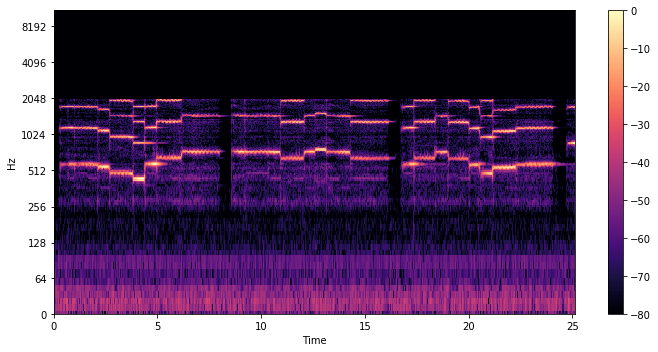

In [23]:
## Plot spectrogram for a single complete song
window_size = int(0.084*sample_rate)
hop_size = int(0.01*sample_rate)

Stft = librosa.stft(song, n_fft = window_size, hop_length=hop_size)
Vft, phase = librosa.magphase(Stft)
#Plot
magnitude = np.zeros((927,2519))
magnitude[:172,:] = Vft[:172,:2519]
plt.figure(figsize=(10,5))
librosa.display.specshow(librosa.amplitude_to_db(magnitude,ref=np.max), x_axis='time', y_axis='log', 
                        sr=sample_rate, hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

In [3]:
## Define a function to lose information from a matrix
def create_reduced_matrix(matrix):
    S = len(matrix)
    T = len(matrix[0])
    reduced_matrix = [[] for k in range(T)]
    #print(reduced_matrix)
    for i in range(T):
        for j in range(S):
            if (matrix[j][i]>0) : reduced_matrix[i].append(matrix[j][i])
        reduced_matrix[i] = sorted(reduced_matrix[i])
    return reduced_matrix

x=[[10,0],[30,0],[15,25],[0,40]]
z = create_reduced_matrix(x)
print(z)
# z[i] empty when no instrument is playing

[[10, 15, 30], [25, 40]]


In [4]:
## Load Pt_fbypa
directory = '/Users/apple/Downloads/store/'
def filepath(filename):
    global directory
    return directory+filename

Pt_fbypa=np.load(filepath('Pt_fbypa_0')+'.npy')
print(Pt_fbypa.shape)
print(np.max(Pt_fbypa), np.min(Pt_fbypa)) 
T,S,A,F = Pt_fbypa.shape

(2519, 4, 7, 172)
0.999987711726259 0.0


In [5]:
## Create the Data Loader

# Create a list of reduced matrices
def create_list_of_reduced_matrices(mats_and_wavs):
    global T
    list_of_reduced_matrices = []
    for i in range(len(mats_and_wavs)):
        matrix = np.array(loadmat(mats_and_wavs[i][5])['GTF0s']).astype('int')
        T = min(T, matrix.shape[1])
        reduced_matrix = create_reduced_matrix(matrix)
        list_of_reduced_matrices.append(reduced_matrix)
    return np.array(list_of_reduced_matrices)


def create_list_of_Pt_fbys(song_paths):
    list_of_Pt_fbys = []
    for i in range(len(song_paths)):
        Pt_f=np.load(filepath('Pt_f_')+str(i)+'.npy')    # shape is (T,F)
        Pt_pszabyf=np.load(filepath('Pt_pszabyf_')+str(i)+'.npy')    # shape is (T,F,P,S,Z,A)
        matrix=np.reshape(Pt_f, list(Pt_f.shape)+[1,1,1,1])*Pt_pszabyf
        print(i, Pt_f.shape, Pt_pszabyf.shape)
        # sum over p,z,a
        matrix=np.sum(matrix, (2,4,5))    # shape is (T,F,S)
        matrix=np.swapaxes(matrix,0,2)    # shape is (S,F,T)
        list_of_Pt_fbys.append(matrix)
    return np.array(list_of_Pt_fbys)


# list_of_red_mat = create_list_of_reduced_matrices(mats_and_wavs)
# list_of_Pt_fbys = create_list_of_Pt_fbys(song_paths)
# np.save(filepath('list_of_red_mat')+'.npy', list_of_red_mat)
# np.save(filepath('list_of_Pt_fbys')+'.npy', list_of_Pt_fbys)
list_of_red_mat = np.load(filepath('list_of_red_mat')+'.npy')
list_of_Pt_fbys = np.load(filepath('list_of_Pt_fbys')+'.npy')


# Create a function to return a one hot vector corresponding to the source at a given p and t
from tensorflow.keras.utils import to_categorical
def one_hot_output(mats_and_wavs, song_path_index, t, p):
    global S
    matrix = np.array(loadmat(mats_and_wavs[song_path_index][5])['GTF0s']).astype('int')
    count=0
    array = sorted(matrix[:,t])
    for s in range(S):
        if array[s]==0 : continue
        else : 
            if p==count : break
            else : count+=1           
    if s<S : 
        label = np.array([s])
        label = to_categorical(label, num_classes = S)
        return label

In [6]:
# Create generator
def generator(list_of_songs, batch_size):
    global Pt_fbypa, mats_and_wavs, list_of_red_mat, list_of_Pt_fbys, T, A, F
    iterate=0
    while True:
        #print(iterate)
        for song_path_index in list_of_songs :
            red_mat = list_of_red_mat[song_path_index]
            Pt_fbys = list_of_Pt_fbys[song_path_index]
            Pt_fbypa = np.load(filepath('Pt_fbypa_'+str(song_path_index))+'.npy')
            # shape of Pt_fbys is [S,F,T]
            batch=0
            for t in range(T):
                for p in range(len(red_mat[t])):
                    if batch<batch_size:
                        input1 = Pt_fbypa[t,p,:,:]
                        input1 = np.reshape(input1, [1]+list(input1.shape)+[1])
                        input2 = Pt_fbys[:,:,t]
                        input2 = np.reshape(input2, [1] + list(input2.shape))
                        outputs = one_hot_output(mats_and_wavs, song_path_index, t, p)
                        if batch==0 : 
                            batch_input1 = input1
                            batch_input2 = input2
                            batch_outputs = outputs
                        else : 
                            batch_input1 = np.concatenate((batch_input1, input1), axis=0)
                            batch_input2 = np.concatenate((batch_input2, input2), axis=0)
                            batch_outputs = np.concatenate((batch_outputs, outputs), axis=0)
                        #print(batch_input1.shape, batch_input2.shape, batch_outputs.shape)
                        batch+=1
                    else : 
                        batch=0
                        inputs = [batch_input1, batch_input2]
                        outputs = batch_outputs
                        yield (inputs, outputs)
        #iterate+=1
list_of_train_songs = [0,1,2,4,6,7,8,9]
list_of_val_songs = [3,5]

def total_examples(list_of_songs):
    total=0
    for song_index in list_of_songs:
        for i in range(len(list_of_red_mat[song_index])):
            total+=len(list_of_red_mat[song_index][i])
    return total

train_samples = total_examples(list_of_train_songs)
val_samples = total_examples(list_of_val_songs)
print(train_samples)
print(val_samples)
train_generator = generator(list_of_train_songs, 32)
val_generator = generator(list_of_val_songs, 16)

92280
26468


In [7]:
## Define a function to avoid NaN gradients
import tensorflow as tf
def inverse_without_nans(x):
    f = lambda x : 1.0/x
    non_zero_mask = tf.not_equal(x, 0.0)
    x_zeros_replaced_by_ones = tf.where(non_zero_mask, x, tf.ones_like(x))
    y_replaced_by_zeros = tf.zeros_like(x)
    y_nans_replaced_by_zeros = tf.where(non_zero_mask, f(x_zeros_replaced_by_ones),
                                                       y_replaced_by_zeros)
    return y_nans_replaced_by_zeros

## Define custom model       
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D
from tensorflow.keras.regularizers import l2

class custom_model(tf.keras.Model):
    global A,F
    def __init__(self):
        super(custom_model,self).__init__()
        self.conv1=Conv2D(input_shape=(A,F,1), filters=1, kernel_size=(3,3), 
                          strides=(1,2), activation = 'relu',
                          kernel_regularizer=l2(0.001))
        self.conv2=Conv2D(filters=1, kernel_size=(2,2), strides = (1,1), activation = 'relu',
                          kernel_regularizer=l2(0.001))
        self.flatten=Flatten()
        self.dense1=Dense(F, activation = 'softmax', kernel_regularizer=l2(0.001))
    
    def call(self, inputs):
        Pt_fbypa_given_tp = inputs[0]
        Pt_fbys = inputs[1]
        #print(Pt_fbypa_given_tp.shape, Pt_fbys_given_t.shape)
        x=self.conv1(Pt_fbypa_given_tp)
        x=self.conv2(x)
        x=self.flatten(x)
        x=self.dense1(x)
        #print(x.shape)
        x=tf.expand_dims(x,1)
        x=Pt_fbys*inverse_without_nans(x)
        #x = tf.where(tf.math.is_nan(x), tf.ones_like(x)*0.0001, x)
        #print(x.shape)
        x = tf.reduce_mean(x,axis=-1)
        #print(x.shape)
        #x=tf.clip_by_value(x, 0.001, 0.999)
        return x

model = custom_model()
# Compile
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['mae', 'acc'])

# Train
model.fit_generator(generator = train_generator, epochs = 1, steps_per_epoch = train_samples/32, 
                    validation_data = val_generator, validation_steps = val_samples/16,
                    verbose = 1, shuffle = True)

2884/2883 [==============================] - 131s 45ms/step - loss: 1.4345 - mae: 2.7883 - acc: 0.2510 - val_loss: 1.4276 - val_mae: 1.9329 - val_acc: 0.2503


In [8]:
## Save weights
model.save_weights('/Users/apple/Downloads/store/DL_weights.h5')

In [23]:
# Random input and output
t = 12
p = 3
Pt_fbys = list_of_Pt_f_per_source[4]
print(len(list_of_red_mat[4][14]))
input1 = Pt_fbypa[t,p,:,:]
input1 = np.reshape(input1, [1]+list(input1.shape)+[1]).astype('float32')
input2 = Pt_fbys[:,:,t]
input2 = np.reshape(input2, [1] + list(input2.shape)).astype('float32')
inputs = [input1, input2]
print(inputs[0].shape)
print(inputs[1].shape)

y = model.conv1(inputs[0])
print(y.shape)
y = model.conv2(y)
print(y.shape)
y = model.flatten(y)
print(y.shape)
# y = model.dense1(y)
# print(y.shape)
outputs = model(inputs)
print(outputs)

4
(1, 5, 172, 1)
(1, 4, 172)
(1, 3, 85, 1)
(1, 2, 84, 1)
(1, 168)
tf.Tensor([[0.9999924 0.9999924 0.9999924 0.9999924]], shape=(1, 4), dtype=float32)


In [ ]:
# Zeros and fours
matrix = np.array(loadmat(mats_and_wavs[1][5])['GTF0s']).astype('int')
reduced_matrix = create_reduced_matrix(matrix)
for t in range(T):
    if len(reduced_matrix[t])!=0 and len(reduced_matrix[t])!=4 :
        print(len(reduced_matrix[t]))

def print_sizes(matrix):
    for i in range(len(matrix[0])):
        count = 0
        for j in range(len(matrix)):
            if matrix[j][t]!=0 : count+=1
        if count !=0 and count != 4 : print(count)
print_sizes(matrix)

In [ ]:
# Concat
# x = tf.random.uniform((2,5,172,1))
# y = tf.random.uniform((1,5,172,1))
# z = tf.concat((x,y),axis=0)
# z.shape

In [21]:
# Gradients
# with tf.GradientTape() as G:
#     G.watch(x)
#     z = inverse_without_nans(x)
#     dz_dx = G.gradient(z,x)
#     print(z, dz_dx)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
train_array = np.array([0.4074, 0.5362, 0.5792, 0.5647, 0.5841, 
                        0.5958, 0.6086, 0.5997, 0.6274, 0.6196])*100
val_array = np.array([0.4721, 0.5380, 0.5424, 0.5633, 0.5770, 
                      0.5724, 0.5701, 0.5838, 0.5894, 0.6105])*100

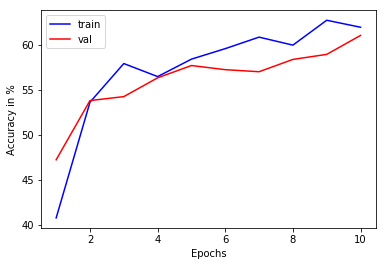

In [29]:
x_axis = np.array([k for k in range(1, 11)])
import pylab
pylab.plot(x_axis, train_array, '-b', label='train')
pylab.plot(x_axis, val_array, '-r', label='val')
pylab.legend(loc='upper left')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy in %', fontsize=10)
plt.show()

In [34]:
#pylab.savefig('../Downloads/DPF1.png')

In [10]:
# Reconstruction
F = 172
T = 2519
song, sample_rate = librosa.load(mats_and_wavs[7][0])
Stft = librosa.stft(song, n_fft = window_size, hop_length=hop_size)
Vft, phase = librosa.magphase(Stft)
Vft = Vft[:,:T]
phase = phase[:,:T]
print(Vft.shape)
IPython.display.Audio(data = song, rate = sample_rate)

(927, 2519)


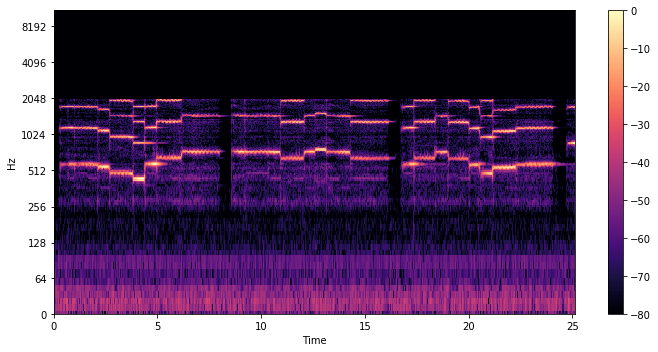

In [18]:
magnitude1 = np.zeros((927,2519))
magnitude1[:172,:] = Vft[:172,:2519]
plt.figure(figsize=(10,5))
librosa.display.specshow(librosa.amplitude_to_db(magnitude1,ref=np.max), 
                         x_axis='time', y_axis='log', 
                        sr=sample_rate, hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

In [19]:
# zero padding
Vft_s = np.load('/Users/apple/Downloads/store/Vft_s_7.npy')
print(phase.shape)
magnitude2 = np.zeros((927,2519))
magnitude2[:172,:] = Vft_s[0,:,:]
x = librosa.istft(magnitude2*phase, win_length = int(window_size), hop_length=hop_size)
IPython.display.Audio(data = x, rate = sample_rate)

(927, 2519)


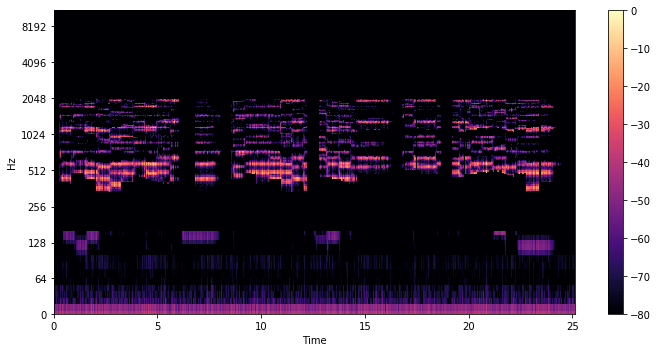

In [20]:
# Stft = librosa.stft(x, n_fft = window_size, hop_length=hop_size)
# magnitude, phase = librosa.magphase(Stft)
# Plot
plt.figure(figsize=(10,5))
librosa.display.specshow(librosa.amplitude_to_db(magnitude2,ref=np.max), 
                         x_axis='time', y_axis='log', sr=sample_rate, hop_length=hop_size)
plt.colorbar()
plt.tight_layout()